In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

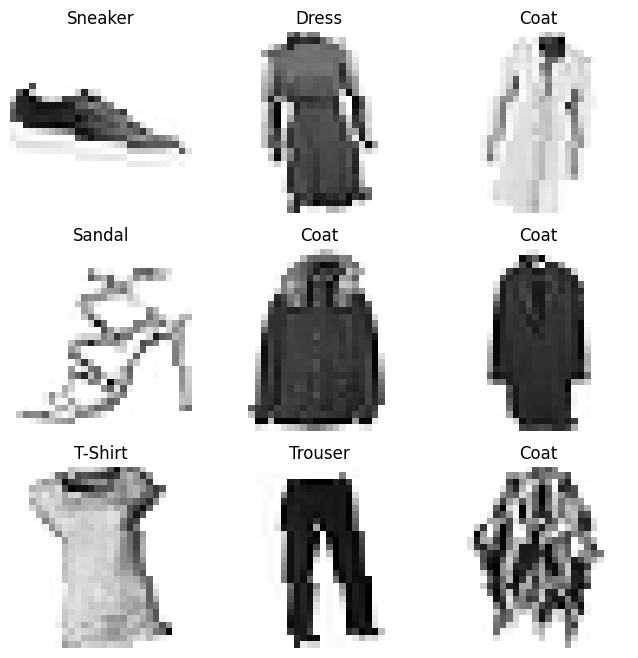

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="Grays")
plt.show()

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 16, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.BatchNorm1d(120),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.BatchNorm1d(84),
            nn.Linear(84, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [5]:
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [6]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [7]:
class NeuralNetwork3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [8]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [9]:
class NeuralNetwork4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [10]:
class NeuralNetwork5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [11]:
class NeuralNetwork6(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 5, 1, 2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 5, 1, 2),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [12]:
class NetworkTrainer:
    def __init__(self, model: nn.Module, 
                 loss_fn: nn.modules.loss._Loss, 
                 optimiser: optim.Optimizer) -> None:
        self.model = model
        self.loss_fn = loss_fn
        self.optimiser = optimiser

    def train_model(self, epochs):
        train_loss_list = []
        train_acc_list = []
        test_loss_list = []
        test_acc_list = []
        for epoch in range(epochs):
            print(f'EPOCH {epoch+1}')
            train_loss, train_acc = self._train_epoch()
            test_loss, test_acc = self._eval_epoch()
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            print(f'Loss: {train_loss:.3f}, Val_Loss: {test_loss:.3f}')
            print(f'Accuracy: {train_acc:.2f}, Val_Accuracy: {test_acc:.2f}\n')
        return train_loss_list, train_acc_list, test_loss_list, test_acc_list

    def _train_epoch(self):
        self.model.train(True)
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(train_dataloader):
            inputs: torch.Tensor = data[0]
            labels = data[1]
            self.optimiser.zero_grad()
            outputs = self.model(inputs)
            loss: torch.Tensor = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(train_data)
        accuracy = 100 * correct / len(train_data)
        return avg_loss, accuracy

    def _eval_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                inputs: torch.Tensor = data[0]
                labels = data[1]
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                running_loss += loss * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(test_data)
        accuracy = 100 * correct / len(test_data)
        return avg_loss, accuracy

In [13]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [14]:
lenet_model = LeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
lenet_optimiser = optim.Adam(lenet_model.parameters(), lr=0.001, weight_decay=0.0001)

In [15]:
print(lenet_model)

LeNet(
  (conv_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=120, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=120, out_features=84, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=84, out_features=10, bias=True)
    (16): Softmax(dim=1)
  )
)


In [16]:
lenet_trainer = NetworkTrainer(lenet_model, loss_fn, lenet_optimiser)
lenet_results = lenet_trainer.train_model(10)

EPOCH 1


Loss: 1.676, Val_Loss: 1.624
Accuracy: 79.93, Val_Accuracy: 83.87

EPOCH 2
Loss: 1.623, Val_Loss: 1.619
Accuracy: 84.01, Val_Accuracy: 84.23

EPOCH 3
Loss: 1.613, Val_Loss: 1.609
Accuracy: 84.98, Val_Accuracy: 85.28

EPOCH 4
Loss: 1.606, Val_Loss: 1.609
Accuracy: 85.61, Val_Accuracy: 85.38

EPOCH 5
Loss: 1.602, Val_Loss: 1.592
Accuracy: 86.04, Val_Accuracy: 86.90

EPOCH 6
Loss: 1.597, Val_Loss: 1.617
Accuracy: 86.40, Val_Accuracy: 84.51

EPOCH 7
Loss: 1.594, Val_Loss: 1.589
Accuracy: 86.82, Val_Accuracy: 87.26

EPOCH 8
Loss: 1.592, Val_Loss: 1.587
Accuracy: 87.01, Val_Accuracy: 87.57

EPOCH 9
Loss: 1.588, Val_Loss: 1.588
Accuracy: 87.46, Val_Accuracy: 87.35

EPOCH 10
Loss: 1.584, Val_Loss: 1.582
Accuracy: 87.77, Val_Accuracy: 87.91



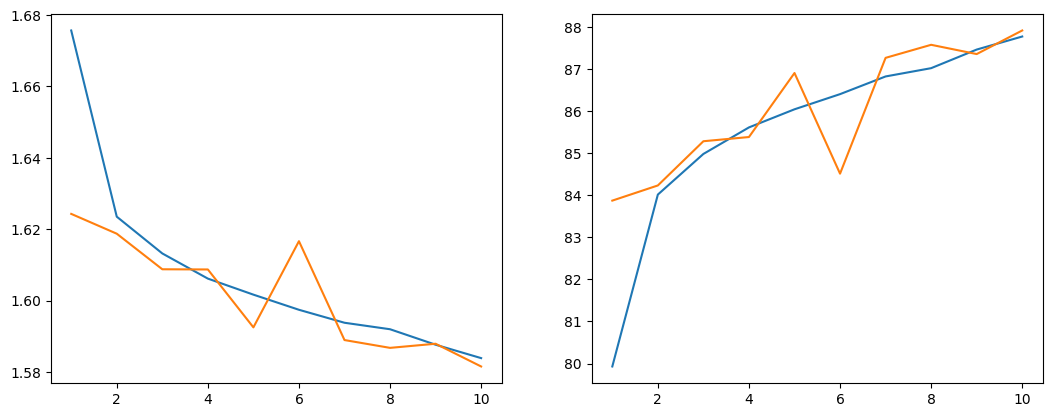

In [17]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = lenet_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,11), train_loss_list)
ax1.plot(range(1,11), test_loss_list)
ax1.set_xticks(range(2,11,2))
ax2.plot(range(1,11), train_acc_list)
ax2.plot(range(1,11), test_acc_list)
ax2.set_xticks(range(2,11,2))
plt.show()

In [18]:
vgg_model = VGG().to(device)
loss_fn = nn.CrossEntropyLoss()
vgg_optimiser = optim.Adam(vgg_model.parameters(), lr=0.001, weight_decay=0.0001)

In [19]:
print(vgg_model)

VGG(
  (conv_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=784, out_f

In [20]:
vgg_trainer = NetworkTrainer(vgg_model, loss_fn, vgg_optimiser)
vgg_results = vgg_trainer.train_model(10)

EPOCH 1
Loss: 1.644, Val_Loss: 1.595
Accuracy: 82.71, Val_Accuracy: 86.81

EPOCH 2
Loss: 1.596, Val_Loss: 1.581
Accuracy: 86.60, Val_Accuracy: 88.08

EPOCH 3
Loss: 1.586, Val_Loss: 1.581
Accuracy: 87.61, Val_Accuracy: 88.04

EPOCH 4
Loss: 1.578, Val_Loss: 1.570
Accuracy: 88.40, Val_Accuracy: 89.06

EPOCH 5
Loss: 1.573, Val_Loss: 1.561
Accuracy: 88.90, Val_Accuracy: 90.25

EPOCH 6
Loss: 1.570, Val_Loss: 1.565
Accuracy: 89.24, Val_Accuracy: 89.77

EPOCH 7
Loss: 1.566, Val_Loss: 1.566
Accuracy: 89.61, Val_Accuracy: 89.54

EPOCH 8
Loss: 1.563, Val_Loss: 1.560
Accuracy: 89.88, Val_Accuracy: 90.09

EPOCH 9
Loss: 1.562, Val_Loss: 1.556
Accuracy: 90.04, Val_Accuracy: 90.61

EPOCH 10
Loss: 1.562, Val_Loss: 1.557
Accuracy: 90.05, Val_Accuracy: 90.47



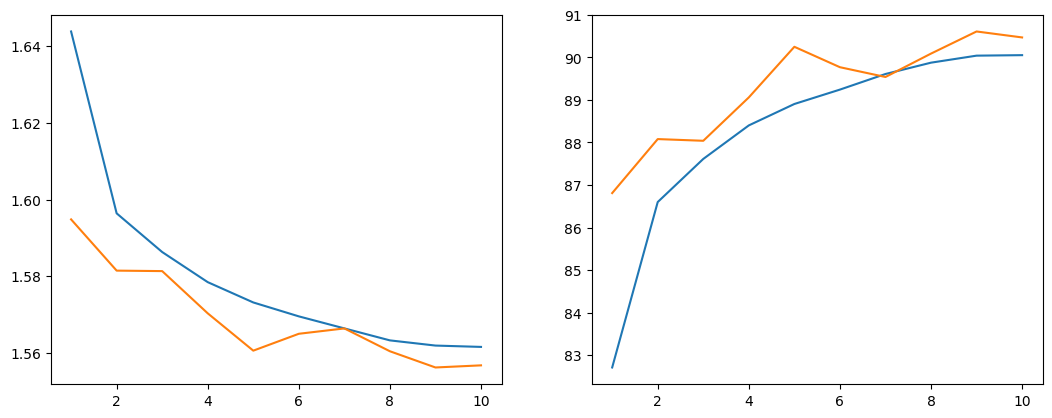

In [21]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = vgg_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,11), train_loss_list)
ax1.plot(range(1,11), test_loss_list)
ax1.set_xticks(range(2,11,2))
ax2.plot(range(1,11), train_acc_list)
ax2.plot(range(1,11), test_acc_list)
ax2.set_xticks(range(2,11,2))
plt.show()

In [22]:
nn1_model = NeuralNetwork1().to(device)
loss_fn = nn.CrossEntropyLoss()
nn1_optimiser = optim.Adam(nn1_model.parameters(), lr=0.001, weight_decay=0.0001)

In [23]:
print(nn1_model)

NeuralNetwork1(
  (conv_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=784, out_features=128, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=128, out_features=10

In [24]:
nn1_trainer = NetworkTrainer(nn1_model, loss_fn, nn1_optimiser)
nn1_results = nn1_trainer.train_model(10)

EPOCH 1
Loss: 1.643, Val_Loss: 1.600
Accuracy: 82.79, Val_Accuracy: 86.37

EPOCH 2
Loss: 1.603, Val_Loss: 1.593
Accuracy: 86.05, Val_Accuracy: 87.00

EPOCH 3
Loss: 1.592, Val_Loss: 1.582
Accuracy: 87.12, Val_Accuracy: 87.98

EPOCH 4
Loss: 1.584, Val_Loss: 1.581
Accuracy: 87.83, Val_Accuracy: 88.14

EPOCH 5
Loss: 1.579, Val_Loss: 1.578
Accuracy: 88.33, Val_Accuracy: 88.41

EPOCH 6
Loss: 1.578, Val_Loss: 1.569
Accuracy: 88.51, Val_Accuracy: 89.23

EPOCH 7
Loss: 1.575, Val_Loss: 1.571
Accuracy: 88.71, Val_Accuracy: 89.16

EPOCH 8
Loss: 1.571, Val_Loss: 1.566
Accuracy: 89.15, Val_Accuracy: 89.67

EPOCH 9
Loss: 1.568, Val_Loss: 1.569
Accuracy: 89.38, Val_Accuracy: 89.19

EPOCH 10
Loss: 1.568, Val_Loss: 1.570
Accuracy: 89.41, Val_Accuracy: 89.21



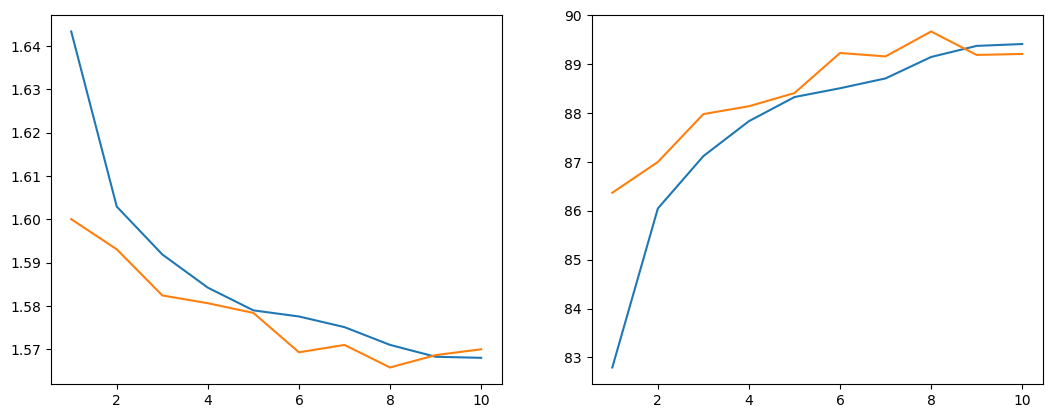

In [25]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = nn1_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,11), train_loss_list)
ax1.plot(range(1,11), test_loss_list)
ax1.set_xticks(range(2,11,2))
ax2.plot(range(1,11), train_acc_list)
ax2.plot(range(1,11), test_acc_list)
ax2.set_xticks(range(2,11,2))
plt.show()

In [26]:
nn2_model = NeuralNetwork2().to(device)
loss_fn = nn.CrossEntropyLoss()
nn2_optimiser = optim.Adam(nn2_model.parameters(), lr=0.001, weight_decay=0.0001)

In [27]:
print(nn2_model)

NeuralNetwork2(
  (conv_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=784, out_features=128, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=128, out_features=10

In [28]:
nn2_trainer = NetworkTrainer(nn2_model, loss_fn, nn2_optimiser)
nn2_results = nn2_trainer.train_model(10)

EPOCH 1


Loss: 1.647, Val_Loss: 1.615
Accuracy: 82.41, Val_Accuracy: 84.80

EPOCH 2
Loss: 1.608, Val_Loss: 1.606
Accuracy: 85.50, Val_Accuracy: 85.62

EPOCH 3
Loss: 1.598, Val_Loss: 1.591
Accuracy: 86.51, Val_Accuracy: 87.13

EPOCH 4
Loss: 1.590, Val_Loss: 1.595
Accuracy: 87.25, Val_Accuracy: 86.63

EPOCH 5
Loss: 1.585, Val_Loss: 1.586
Accuracy: 87.71, Val_Accuracy: 87.54

EPOCH 6
Loss: 1.582, Val_Loss: 1.576
Accuracy: 87.93, Val_Accuracy: 88.51

EPOCH 7
Loss: 1.578, Val_Loss: 1.587
Accuracy: 88.38, Val_Accuracy: 87.65

EPOCH 8
Loss: 1.574, Val_Loss: 1.578
Accuracy: 88.78, Val_Accuracy: 88.27

EPOCH 9
Loss: 1.573, Val_Loss: 1.578
Accuracy: 88.92, Val_Accuracy: 88.35

EPOCH 10
Loss: 1.571, Val_Loss: 1.575
Accuracy: 89.19, Val_Accuracy: 88.68



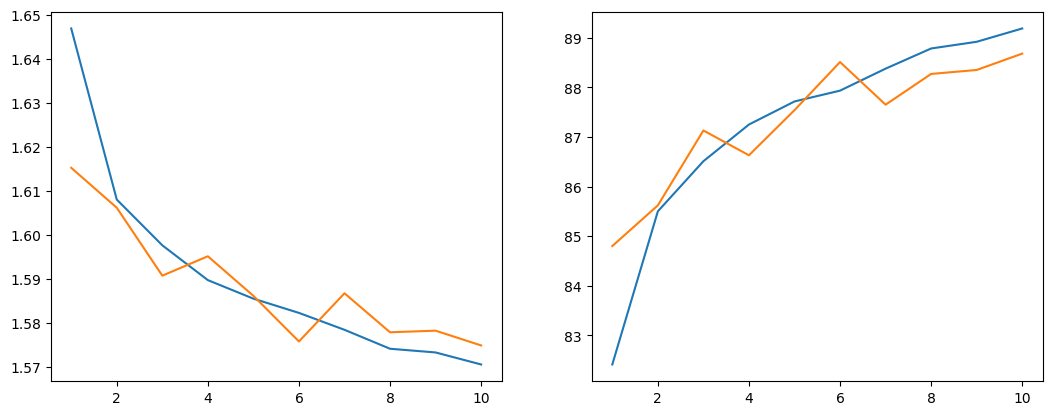

In [29]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = nn2_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,11), train_loss_list)
ax1.plot(range(1,11), test_loss_list)
ax1.set_xticks(range(2,11,2))
ax2.plot(range(1,11), train_acc_list)
ax2.plot(range(1,11), test_acc_list)
ax2.set_xticks(range(2,11,2))
plt.show()

In [30]:
nn3_model = NeuralNetwork3().to(device)
loss_fn = nn.CrossEntropyLoss()
nn3_optimiser = optim.Adam(nn3_model.parameters(), lr=0.001, weight_decay=0.0001)

In [31]:
print(nn3_model)

NeuralNetwork3(
  (conv_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=784, out_features=128, bias=True)
    (10): ReLU()
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Linear(in_features=128, out_features=10

In [32]:
nn3_trainer = NetworkTrainer(nn3_model, loss_fn, nn3_optimiser)
nn3_results = nn3_trainer.train_model(10)

EPOCH 1
Loss: 1.648, Val_Loss: 1.606
Accuracy: 82.34, Val_Accuracy: 85.77

EPOCH 2
Loss: 1.603, Val_Loss: 1.593
Accuracy: 85.98, Val_Accuracy: 86.99

EPOCH 3
Loss: 1.593, Val_Loss: 1.585
Accuracy: 87.00, Val_Accuracy: 87.84

EPOCH 4
Loss: 1.585, Val_Loss: 1.594
Accuracy: 87.66, Val_Accuracy: 86.80

EPOCH 5
Loss: 1.580, Val_Loss: 1.579
Accuracy: 88.25, Val_Accuracy: 88.17

EPOCH 6
Loss: 1.576, Val_Loss: 1.581
Accuracy: 88.56, Val_Accuracy: 88.14

EPOCH 7
Loss: 1.574, Val_Loss: 1.570
Accuracy: 88.83, Val_Accuracy: 89.14

EPOCH 8
Loss: 1.572, Val_Loss: 1.573
Accuracy: 89.01, Val_Accuracy: 88.83

EPOCH 9
Loss: 1.567, Val_Loss: 1.562
Accuracy: 89.43, Val_Accuracy: 89.94

EPOCH 10
Loss: 1.572, Val_Loss: 1.566
Accuracy: 89.00, Val_Accuracy: 89.49



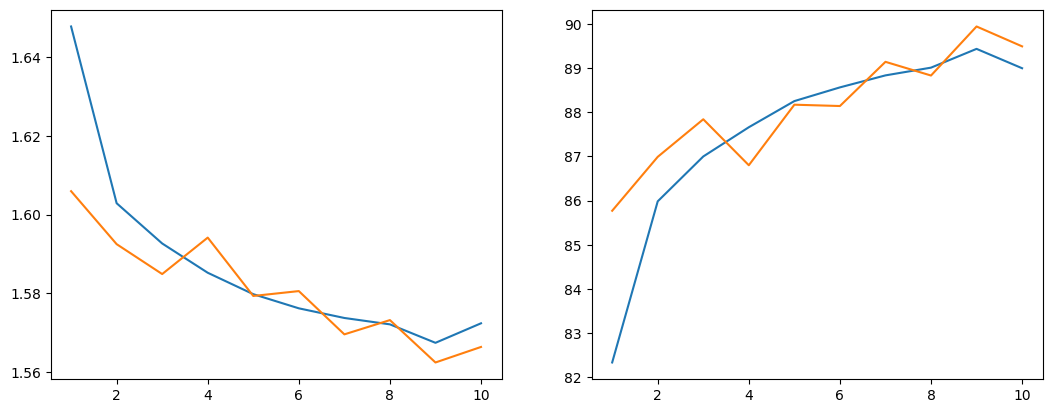

In [33]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = nn3_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,11), train_loss_list)
ax1.plot(range(1,11), test_loss_list)
ax1.set_xticks(range(2,11,2))
ax2.plot(range(1,11), train_acc_list)
ax2.plot(range(1,11), test_acc_list)
ax2.set_xticks(range(2,11,2))
plt.show()

In [34]:
nn4_model = NeuralNetwork4().to(device)
loss_fn = nn.CrossEntropyLoss()
nn4_optimiser = optim.Adam(nn4_model.parameters(), lr=0.001, weight_decay=0.0001)

In [35]:
print(nn4_model)

NeuralNetwork4(
  (conv_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features

In [36]:
nn4_trainer = NetworkTrainer(nn4_model, loss_fn, nn4_optimiser)
nn4_results = nn4_trainer.train_model(10)

EPOCH 1
Loss: 1.648, Val_Loss: 1.595
Accuracy: 82.26, Val_Accuracy: 86.71

EPOCH 2
Loss: 1.599, Val_Loss: 1.583
Accuracy: 86.32, Val_Accuracy: 87.75

EPOCH 3
Loss: 1.585, Val_Loss: 1.572
Accuracy: 87.72, Val_Accuracy: 88.91

EPOCH 4
Loss: 1.580, Val_Loss: 1.585
Accuracy: 88.24, Val_Accuracy: 87.62

EPOCH 5
Loss: 1.572, Val_Loss: 1.563
Accuracy: 88.98, Val_Accuracy: 89.95

EPOCH 6
Loss: 1.569, Val_Loss: 1.568
Accuracy: 89.34, Val_Accuracy: 89.37

EPOCH 7
Loss: 1.566, Val_Loss: 1.566
Accuracy: 89.65, Val_Accuracy: 89.55

EPOCH 8
Loss: 1.565, Val_Loss: 1.560
Accuracy: 89.72, Val_Accuracy: 90.08

EPOCH 9
Loss: 1.563, Val_Loss: 1.558
Accuracy: 89.95, Val_Accuracy: 90.20

EPOCH 10
Loss: 1.560, Val_Loss: 1.563
Accuracy: 90.16, Val_Accuracy: 89.93



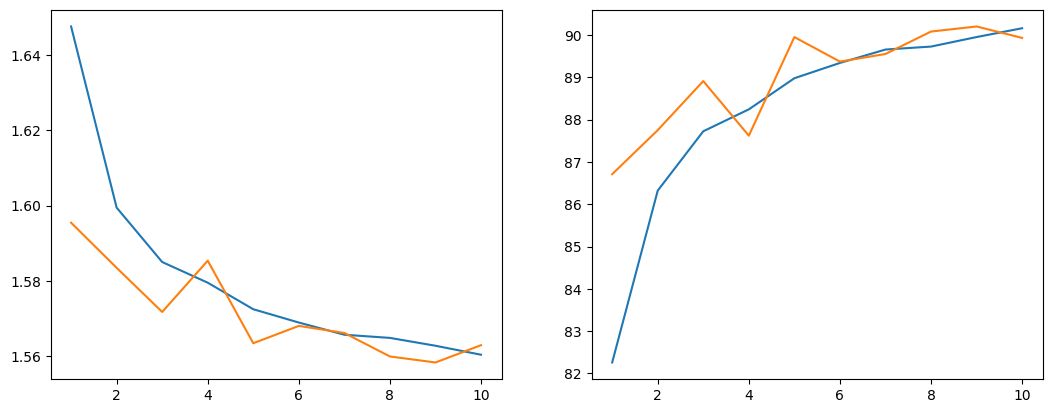

In [37]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = nn4_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,11), train_loss_list)
ax1.plot(range(1,11), test_loss_list)
ax1.set_xticks(range(2,11,2))
ax2.plot(range(1,11), train_acc_list)
ax2.plot(range(1,11), test_acc_list)
ax2.set_xticks(range(2,11,2))
plt.show()

In [38]:
nn5_model = NeuralNetwork5().to(device)
loss_fn = nn.CrossEntropyLoss()
nn5_optimiser = optim.Adam(nn5_model.parameters(), lr=0.001, weight_decay=0.0001)

In [39]:
print(nn5_model)

NeuralNetwork5(
  (conv_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features

In [40]:
nn5_trainer = NetworkTrainer(nn5_model, loss_fn, nn5_optimiser)
nn5_results = nn5_trainer.train_model(10)

EPOCH 1
Loss: 1.649, Val_Loss: 1.602
Accuracy: 82.08, Val_Accuracy: 86.03

EPOCH 2
Loss: 1.601, Val_Loss: 1.596
Accuracy: 86.19, Val_Accuracy: 86.62

EPOCH 3
Loss: 1.588, Val_Loss: 1.578
Accuracy: 87.44, Val_Accuracy: 88.29

EPOCH 4
Loss: 1.581, Val_Loss: 1.572
Accuracy: 88.14, Val_Accuracy: 88.96

EPOCH 5
Loss: 1.577, Val_Loss: 1.568
Accuracy: 88.50, Val_Accuracy: 89.36

EPOCH 6
Loss: 1.571, Val_Loss: 1.575
Accuracy: 89.11, Val_Accuracy: 88.59

EPOCH 7
Loss: 1.568, Val_Loss: 1.565
Accuracy: 89.38, Val_Accuracy: 89.64

EPOCH 8
Loss: 1.565, Val_Loss: 1.570
Accuracy: 89.68, Val_Accuracy: 89.31

EPOCH 9
Loss: 1.563, Val_Loss: 1.561
Accuracy: 89.89, Val_Accuracy: 89.89

EPOCH 10
Loss: 1.561, Val_Loss: 1.572
Accuracy: 90.09, Val_Accuracy: 89.02



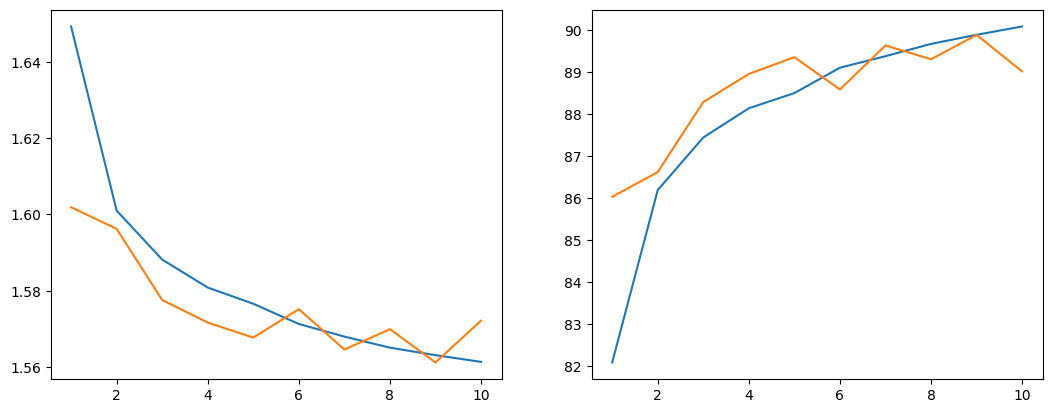

In [41]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = nn5_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,11), train_loss_list)
ax1.plot(range(1,11), test_loss_list)
ax1.set_xticks(range(2,11,2))
ax2.plot(range(1,11), train_acc_list)
ax2.plot(range(1,11), test_acc_list)
ax2.set_xticks(range(2,11,2))
plt.show()

In [42]:
nn6_model = NeuralNetwork6().to(device)
loss_fn = nn.CrossEntropyLoss()
nn6_optimiser = optim.Adam(nn6_model.parameters(), lr=0.001, weight_decay=0.0001)

In [43]:
print(nn6_model)

NeuralNetwork6(
  (conv_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU()
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features

In [45]:
nn6_trainer = NetworkTrainer(nn6_model, loss_fn, nn6_optimiser)
nn6_results = nn6_trainer.train_model(10)

EPOCH 1
Loss: 1.654, Val_Loss: 1.612
Accuracy: 81.56, Val_Accuracy: 84.98

EPOCH 2
Loss: 1.610, Val_Loss: 1.593
Accuracy: 85.32, Val_Accuracy: 87.01

EPOCH 3
Loss: 1.594, Val_Loss: 1.588
Accuracy: 86.77, Val_Accuracy: 87.29

EPOCH 4
Loss: 1.586, Val_Loss: 1.577
Accuracy: 87.63, Val_Accuracy: 88.53

EPOCH 5
Loss: 1.582, Val_Loss: 1.578
Accuracy: 88.08, Val_Accuracy: 88.37

EPOCH 6
Loss: 1.576, Val_Loss: 1.579
Accuracy: 88.61, Val_Accuracy: 88.10

EPOCH 7
Loss: 1.572, Val_Loss: 1.567
Accuracy: 89.11, Val_Accuracy: 89.28

EPOCH 8
Loss: 1.569, Val_Loss: 1.568
Accuracy: 89.32, Val_Accuracy: 89.41

EPOCH 9
Loss: 1.566, Val_Loss: 1.561
Accuracy: 89.65, Val_Accuracy: 90.08

EPOCH 10
Loss: 1.565, Val_Loss: 1.567
Accuracy: 89.69, Val_Accuracy: 89.26



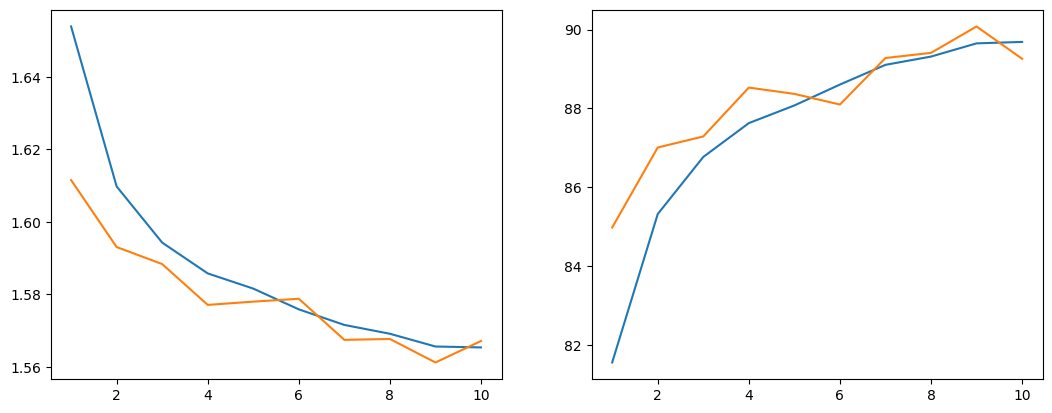

In [46]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = nn6_results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
ax1.plot(range(1,11), train_loss_list)
ax1.plot(range(1,11), test_loss_list)
ax1.set_xticks(range(2,11,2))
ax2.plot(range(1,11), train_acc_list)
ax2.plot(range(1,11), test_acc_list)
ax2.set_xticks(range(2,11,2))
plt.show()